## Exercise #3 - Breast cancer prediction

In [1]:
# import the necessary dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [2]:
# load the data
data = pd.read_csv("Breast_cancer_data.csv")
data.head(10)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean
0,0,17.99,10.38,122.80,1001.0,0.11840
1,0,20.57,17.77,132.90,1326.0,0.08474
2,0,19.69,21.25,130.00,1203.0,0.10960
3,0,11.42,20.38,77.58,386.1,0.14250
4,0,20.29,14.34,135.10,1297.0,0.10030
5,0,12.45,15.70,82.57,477.1,0.12780
6,0,18.25,19.98,119.60,1040.0,0.09463
7,0,13.71,20.83,90.20,577.9,0.11890
8,0,13.00,21.82,87.50,519.8,0.12730
9,0,12.46,24.04,83.97,475.9,0.11860


Basic Exploratory Data Analysis

<Axes: >

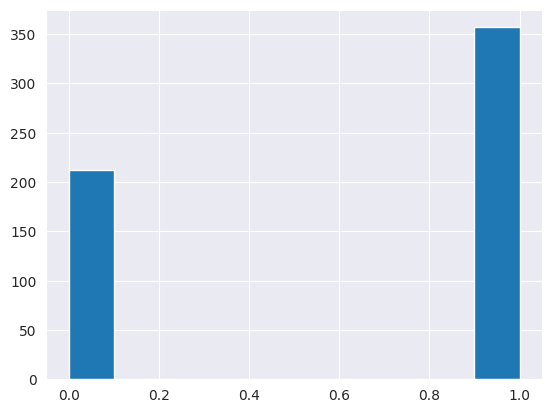

In [3]:
# histograms for the labels 0 (no cancer) and 1 (has cancer)
data["diagnosis"].hist()

<Axes: >

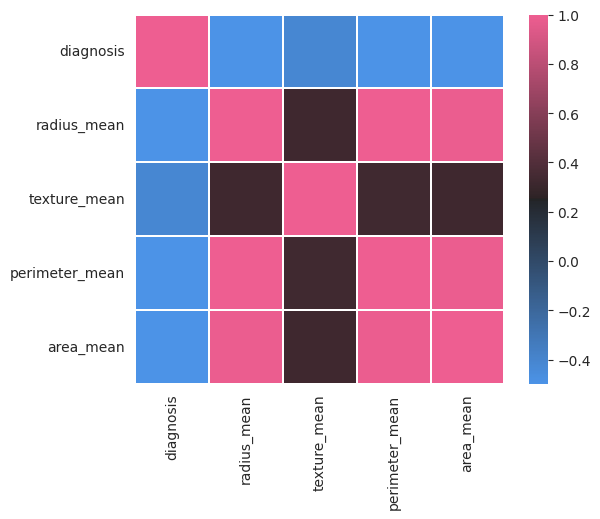

In [4]:
# plot heatmap to show the correlation between various variables
corr = data.iloc[:,:-1].corr(method="pearson")
cmap = sns.diverging_palette(250,354,80,60,center='dark',as_cmap=True)
sns.heatmap(corr, vmax=1, vmin=-.5, cmap=cmap, square=True, linewidths=.2)

In [5]:
# perimeter and area have high positive correlation with radius, so we can get rid of them
data = data[["radius_mean", "texture_mean", "smoothness_mean", "diagnosis"]]
data.head(10)

,radius_mean,texture_mean,smoothness_mean,diagnosis
0,17.99,10.38,0.11840,0
1,20.57,17.77,0.08474,0
2,19.69,21.25,0.10960,0
3,11.42,20.38,0.14250,0
4,20.29,14.34,0.10030,0
5,12.45,15.70,0.12780,0
6,18.25,19.98,0.09463,0
7,13.71,20.83,0.11890,0
8,13.00,21.82,0.12730,0
9,12.46,24.04,0.11860,0


Make histogram plots of these variables along with their kde plots

<Axes: xlabel='texture_mean', ylabel='Count'>

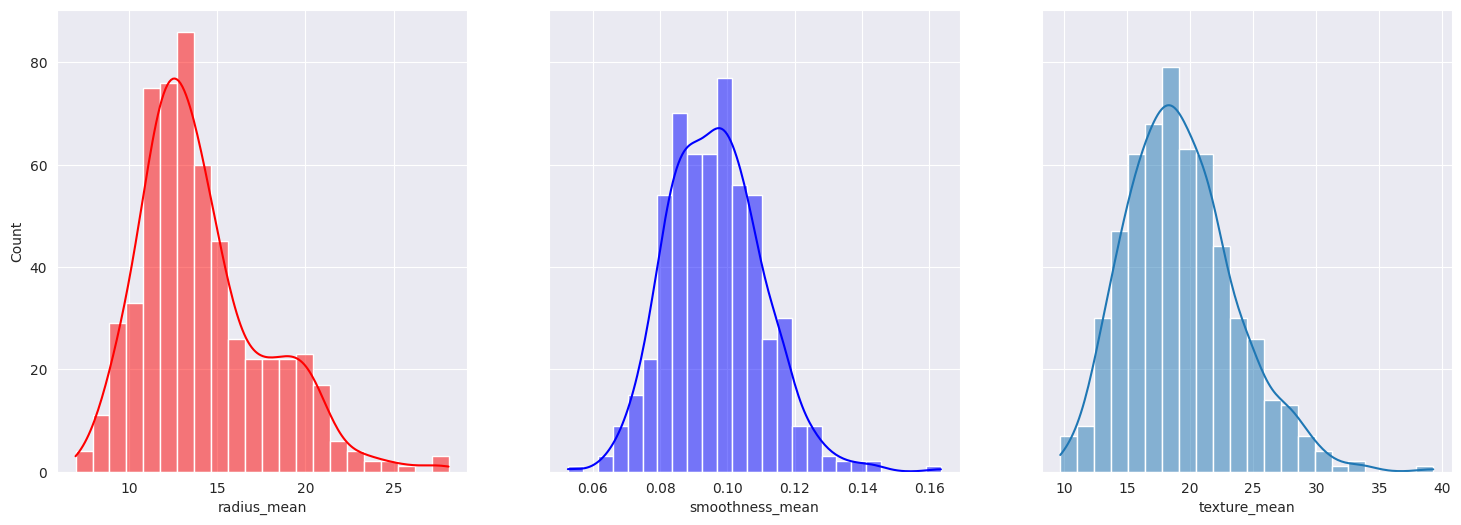

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
sns.histplot(data, ax=axes[0], x="radius_mean", kde=True, color='r')
sns.histplot(data, ax=axes[1], x="smoothness_mean", kde=True, color='b')
sns.histplot(data, ax=axes[2], x="texture_mean", kde=True)

Calculate P(Y=y) for all possible y

In [7]:
def calculate_prior(df, Y):
    classes = sorted(list(df[Y].unique()))
    prior = []
    for i in classes:
        prior.append(len(df[df[Y]==i])/len(df))
    return prior

Calculate P(X=x|Y=y) using Gaussian distribution.

Compute the likelihood of a given feature value belonging to a certain class (label) based on a Gaussain distribution.

In [8]:
def calculate_likelihood_gaussian(df, feat_name, feat_val, Y, label):
    feat = list(df.columns) # get the column names from the dataframe df
    df = df[df[Y]==label] # filter to include only those rows where Y has a specific label
    mean, std = df[feat_name].mean(), df[feat_name].std() # get mean and std dev for a feature
    p_x_given_y = (1 / (np.sqrt(2 * np.pi) * std)) *  np.exp(-((feat_val-mean)**2 / (2 * std**2 )))
    return p_x_given_y

Compute the probability of X given a certain label y for all the Xs (features).

In [9]:
def naive_bayes_gaussian(df, X, Y): # dataframe, features and labels
    # get feature names
    features = list(df.columns)[:-1] # get the features, except the last column
    # the last column is a target variable

    # calculate prior probabilities using previously defined function
    prior = calculate_prior(df, Y)

    # initialize an empty list to store the predicted class labels for each data sample
    Y_pred = []

    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        # create a list of length 'len(labels) where each element is '1'.
        # this is a common practice to create a list with same initial value
        # repeated multiple times. it acts as a placeholder for probabilities
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_gaussian(df, features[i], x[i], Y, labels[j])
        # this block calculates the likelihood of the observed features 'x' given
        # each class label. it iterates over all unique class lables, computes
        # the likelihood for each feature, and multiplies them together to get
        # the likelihood for each class label

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        # after calculating the posterior probabilities for each class label, select
        # the class label with the highest posterior probability as the predicted
        # class label for the current data sample and append it to the list Y_pred
        Y_pred.append(np.argmax(post_prob))

    # finally, return an array containing the predicted class lables for all data samples
    return np.array(Y_pred)

## Test Gaussian model

In [10]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=.2, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_gaussian(train, X=X_test, Y="diagnosis")

from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))

[[36  4]
 [ 0 74]]
0.9736842105263158
